## Binary Classifier for Punta Cana Hotels Reviews - Sentiment Analysis
\
The dataset [Punta Cana dataset](https://raw.githubusercontent.com/beltrewilton/binary_classifier/master/data/punta_cana.csv) of users reviews was scraped using [tripadvisor-scraper](https://github.com/beltrewilton/tripadvisor-scraper). (Which was also made for this purpose).\
The full dataset was scraped filtered by **Spanish** lang comments, but if you like, you can play with this and looking for comments in English, Portuguese and another city.
\
\
The purpose of this notebook is purely academic, so it is avoided to use libraries such as [scikit-learn](https://scikit-learn.org/), for this reason implemented algorithms are developed from scratch.
\
\
Below are two random exampls from our dataset.

<img src="https://raw.githubusercontent.com/beltrewilton/binary_classifier/master/resources/sample.PNG">

Next, the utility libraries of the entire project will be loaded, accompanied by some lazy comments.

In [8]:
import numpy as np  # Numerical Python, used here to perform numerical vector calcs and some random states.
import pandas as pd # We will use it to load the dataset and manipulate the data on high level.
import matplotlib.pyplot as plt # To compare accuracy and track visually.
import seaborn as sns  

from tqdm.notebook import tqdm_notebook # to see the progress of the algorithm iterations.
from IPython.display import display, Markdown 

import utils # utility functions.

pd.plotting.register_matplotlib_converters()
%matplotlib inline
print('Libs loaded.')

Libs loaded.


#### Here we go with our dataset load using pandas
\
This one has more interesting columns, but for our purpose we are only interested in ```rating``` and ```review_text```.

In [12]:
# file_path = './data/punta_cana.csv'
file_path = 'https://raw.githubusercontent.com/beltrewilton/binary_classifier/master/data/punta_cana.csv'
df = pd.read_csv(file_path, usecols=['rating', 'review_text'])

comments, cols = df.shape
display(Markdown('The file \'{}\' has {:,} comments as rows and {} columns, yes rating and review_text columns.'.format(file_path, comments, cols)))

The file 'https://raw.githubusercontent.com/beltrewilton/binary_classifier/master/data/punta_cana.csv' has 34,561 comments as rows and 2 columns, yes rating and review_text columns.

#### The beauty of ```numpy.split``` for split our dataset
\
Check out this quickie example, from the following array ```fib```, we are going to split from index 0 to index 5, from index 6 to index 8 and from index 9 to 11 (until the end).\
In a manual way it would be:
```python 
fib[:6]
fib[6:9]
fib[9:]
```

We obtain this particular result using ```numpy.split```
```python 
fib = np.array([0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89])
np.split(fib, [6, 9])
```
Now suppose that instead of an array of size 12 what we have is a much larger array, it would be tedious to find the correct indices.\
That is why we look for the proportions, it would look something like this:
```python
[int(.5*len(df)), int(.75*len(df))]
```
<img src="https://raw.githubusercontent.com/beltrewilton/binary_classifier/master/resources/np_split.png">

With this knowledge we can split our data, before mentioning that ```df.sample``` makes our dataset randomly rearranged.\
Why random_state=42?, well look at this [Answer To The Ultimate Question](https://www.youtube.com/watch?v=5ZLtcTZP2js&t=83s)
\
\
\
#### Okay let's do It.
We will split our dataset as follows:
 - train_data 60%
 - validate_data 20%
 - test_data 20%

In [3]:
train_data, validate_data, test_data = np.split(df.sample(frac=1, random_state=42).values,  [int(.6*len(df)), int(.8*len(df))])

In [9]:
train_data.shape, validate_data.shape, test_data.shape  # now we have 3 arrays of 2 columns and a lot of rows.


((20736, 2), (6912, 2), (6913, 2))

### From reviews to vectors

\
So, to do this possible we must convert all the text into numbers, we will use the **bag of words** approach and our mapping would be the **unigram model**.
\
We will focus on algorithms, then the we will use [util function](./utils.py) for extract unigram worlds and convert to vector representation.
\
\
Well, we need a dictionary based on ```train_data``` (60% of the dataset).
\
In the hypothetical case, we assume that 60% of the dataset corresponds to the following two observations:\
_'Todo fue muy bueno en el hotel.'_
\
_'El desayuno del hotel estuvo bueno.'_
\
\
The dictionary (60%) will keep the non-repeated words:
\
_{Todo, fue, muy, bueno, en, el, hotel, desayuno, del, estuvo}_
\
\
Now let's transform an observation  _'Un hotel bueno para la familia.'_  (represents ```validate_data``` 20%)

Todo| fue| muy| bueno| en| el| hotel| desayuno| del| estuvo
:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:
0| 0| 0| 1| 0| 0| 1| 0| 0| 0

\
A vector of the same length as the dictionary length is produced {0, 0, 0, 1, 0, 0, 1, 0, 0, 0}.
\
Based on this assumption, the dictionary below is created.


In [6]:
dictionary = utils.unigram_words(train_data[:, 1])
break_point = 3

In [7]:
X_train = utils.extract_unigram_vectors(train_data[:, 1], dictionary)
X_validate = utils.extract_unigram_vectors(validate_data[:, 1], dictionary)
X_test = utils.extract_unigram_vectors(test_data[:, 1], dictionary)


In [8]:
X_train.shape, X_validate.shape, X_test.shape

((20736, 42609), (6912, 42609), (6913, 42609))

### Labels

Next, the 'rating' column is taken for each proportion.\
The reviews rating, originally given on a 5 point scale, have been adjusted to a +1 or -1 scale, representing a positive or negative review, respectively.

In [9]:
Y_train = train_data[:, 0]
Y_validate = validate_data[:, 0]
Y_test = test_data[:, 0]

In [10]:
Y_train.shape, Y_validate.shape, Y_test.shape

((20736,), (6912,), (6913,))

In [11]:
for Y in [Y_train, Y_validate, Y_test]:
    Y[Y <= break_point] = -1
    Y[Y > break_point] = 1

In [12]:
Y_validate

array([1, 1, 1, ..., 1, -1, 1], dtype=object)

### Perceptron
\
A training set is said to be **linearly separable** if it exists a linear classifier that correctly
classifies all the training examples (i.e. if parameter $\hat{\theta}$ and $\hat{\theta_0}$ exists such that $y^i * (\hat{\theta} \cdot x^i + \hat{\theta_0}) > 0 $ for all $i = 1, \dots, n$)
\
When the output of a classifier is exactly 0, if the example lies exactly on the **linear
boundary**, we count that as an error, since we don’t know which way we should really
classify that point.
\
\
#### Through the origin classifier
 - We start with a  $\theta = 0$ (vector) parameter
 - We check if, with this parameter, the classifier make an error
 - If so, we progressively update the classifier
 - This is the task for the ```__update``` function code.
 \
 \
 Now, what are we going to do here over the whole training set, is we start with the 0
parameter vector and then go over all the training examples. And if the i-th example is a
mistake, then we perform that update that we just discussed.
\
\
```python
def perceptron(self, X, Y, T) -> (np.ndarray, float)
```
So we have to go through the training set here multiple times, here capital T times go
through the training set, either in order or select at random, look at whether it’s a mistake,
and perform a simple update (```__update```).


In [13]:
class PerceptronClassifier:
    def __init__(self):
        pass

    def __update(self, x, y, theta, theta_0) -> (np.ndarray, float):
        if y * (np.dot(theta, x) + theta_0) <= 0:
            theta = theta + (y * x)
            theta_0 = theta_0 + y

        return theta, theta_0

    def perceptron(self, X, Y, T) -> (np.ndarray, float):
        n, f = X.shape
        theta = np.zeros(f)
        theta_0 = 0
        for t in range(T):
            order = np.arange(n)
            np.random.shuffle(order)
            for i in tqdm_notebook(order, desc = 'Iteration T: {}'.format(t), leave=False):
                theta, theta_0 = self.__update(X[i], Y[i], theta, theta_0)

        return theta, theta_0

    def perceptron_avg(self, X, Y, T) -> (np.ndarray, float):
        n, f = X.shape
        theta = np.zeros(f)
        theta_s = np.zeros(f)
        theta_0 = 0
        theta_0_s = 0
        for t in range(T):
            order = np.arange(n)
            np.random.shuffle(order)
            for i in tqdm_notebook(order, desc = 'Iteration T: {}'.format(t), leave=False):
                theta, theta_0 = self.__update(X[i], Y[i], theta, theta_0)
                theta_s += theta
                theta_0_s += theta_0

        return theta_s / (n * T), theta_0_s / (n * T)
    

### Pegasos
\
The  parameter $\eta$ is a decaying factor that will decrease over time. The  parameter $\lambda$ is a regularizing parameter, [more info](https://courses.edx.org/assets/courseware/v1/16f13f7ac37ae86ebe0372f2410bcec4/asset-v1:MITx+6.86x+3T2021+type@asset+block/resources_pegasos.pdf)
\
In this problem, you will need to adapt this update rule to add a bias term ($\theta_0$) to the hypothesis, but take care not to penalize the magnitude of $\theta_0$.
\
\
Rule:
\
If $y^i (\theta\cdot x^i) <= 1 $
\
then
$\theta = (1 - \eta \lambda) \theta + \eta y^i x^i$
\
otherwise
$\theta = (1 - \eta \lambda) \theta $

In [14]:
class PegasosClassifier:
    def __init__(self):
        pass

    def __update(self, x, y, L, eta, theta, theta_0) -> (np.ndarray, float):
        if y * (np.dot(theta, x) + theta_0) <= 1:
            theta = ((1 - (eta * L)) * theta) + (eta * y * x)
            # [optional]
            # current_theta = min(1, (1/np.sqrt(L)) / np.linalg.norm(current_theta)) * current_theta
            theta_0 = theta_0 + (eta * y)
        else:
            theta = (1 - (eta * L)) * theta

        return theta, theta_0

    def pegasos(self, X, Y, T, L) -> (np.ndarray, float):
        n, f = X.shape
        theta = np.zeros(f)
        theta_0 = 0
        counter = 1
        eta = 1 / np.sqrt(counter)
        for t in range(T):
            order = np.arange(n)
            np.random.shuffle(order)
            for i in tqdm_notebook(order, desc = 'Iteration T: {}'.format(t), leave=False):
                theta, theta_0 = self.__update(X[i], Y[i], L, eta, theta, theta_0)
                counter += 1
                eta = 1 / np.sqrt(counter)

        return theta, theta_0
    

### Classifier class

* This class is the starting point for training and validating our dataset. Using poo inherits the functionalities of Perceptron and Pegasos.
\
* The ```classify``` method makes the prediction with the "optimal" values of theta, this is the dot product of X and theta transposed.\
* Then adjusteting to a +1 or -1 scale for representing a positive or negative review of prediction.
\
* The ```accuracy``` method allows you to see how similar the prediction is to the target.
\
* ```classifier_accuracy```   is a "main" method in the class, so from this point the training vector is iterated over one particular algorithm _(Perceptron, Perceptron avg or Pegasos)_ to obtain the prediction and some accuracy.

In [13]:
class Classifier(PerceptronClassifier, PegasosClassifier):
    def __init__(self, X_train, X_val, Y_train, Y_val, T):
        self.X_train = X_train
        self.X_val = X_val
        self.Y_train = Y_train
        self.Y_val = Y_val
        self.T = T

    def accuracy(self, preds, targets) -> float:
        return (preds == targets).mean()

    def classify(self, X, theta, theta_0) -> np.ndarray:
        preds = (np.dot(X, theta.T)) + theta_0
        preds[preds > 0] = 1
        preds[preds <= 0] = -1
        return preds

    def classifier_accuracy(self, classifier, L=None) -> (float, float):
        print("{} -> T: {}, L: {}".format(classifier, self.T, L))
        if self.T and L:
            theta, theta_0 = classifier(self.X_train, self.Y_train, self.T, L)
        elif self.T:
            theta, theta_0 = classifier(self.X_train, self.Y_train, self.T)

        Y_train_predicted = self.classify(self.X_train, theta, theta_0)
        X_val_predicted = self.classify(self.X_val, theta, theta_0)

        accuracy_train = self.accuracy(Y_train_predicted, self.Y_train)
        accuracy_val = self.accuracy(X_val_predicted, self.Y_val)

        return accuracy_train, accuracy_val

    def tune(self, train_fn, param_vals, train_feats, train_labels, val_feats, val_labels):
        train_accs = np.ndarray(len(param_vals))
        val_accs = np.ndarray(len(param_vals))

        for i, val in enumerate(param_vals):
            theta, theta_0 = train_fn(train_feats, train_labels, val)

            train_preds = self.classify(train_feats, theta, theta_0)
            train_accs[i] = self.accuracy(train_preds, train_labels)

            val_preds = self.classify(val_feats, theta, theta_0)
            val_accs[i] = self.accuracy(val_preds, val_labels)

        return train_accs, val_accs

    def tune_perceptron(self, *args):
        return self.tune(self.perceptron, *args)

    def tune_avg_perceptron(self, *args):
        return self.tune(self.perceptron_avg, *args)

    def tune_pegasos_T(self, best_L, *args):
        def train_fn(features, labels, T):
            return self.pegasos(features, labels, T, best_L)

        return self.tune(train_fn, *args)

    def tune_pegasos_L(self, best_T, *args):
        def train_fn(features, labels, L):
            return self.pegasos(features, labels, best_T, L)

        return self.tune(train_fn, *args)

    def most_explanatory_word(self, theta, wordlist):
        """Returns the word associated with the bag-of-words feature having largest weight."""
        # theta(i) mientras mas grande es es mas explanatory_word / positive,
        # el indice asociado theta[i], wordlist[i] se mueve en par cuando se hace sort.
        return [word for (theta_i, word) in sorted(zip(theta, wordlist))[::-1]]

NameError: name 'PerceptronClassifier' is not defined

### Running the Classifier
\
Let's run the classifier with some static parameters, each of the algorithms will do 10 T runs.
\
The objective is to observe which of them presents the highest training and validation accuracy.

In [16]:
T = 10
L = 0.01
clf = Classifier(X_train, X_validate, Y_train, Y_validate, T=T)

In [18]:
pct_train_accuracy, pct_val_accuracy = clf.classifier_accuracy(clf.perceptron)
print("{:35} {:.4f}".format("Training accuracy for perceptron:", pct_train_accuracy))
print("{:35} {:.4f}".format("Validation accuracy for perceptron:", pct_val_accuracy))

avg_pct_train_accuracy, avg_pct_val_accuracy =  clf.classifier_accuracy(clf.perceptron_avg)
print("{:43} {:.4f}".format("Training accuracy for average perceptron:", avg_pct_train_accuracy))
print("{:43} {:.4f}".format("Validation accuracy for average perceptron:", avg_pct_val_accuracy))

avg_peg_train_accuracy, avg_peg_val_accuracy =  clf.classifier_accuracy(clf.pegasos, L=L)
print("{:50} {:.4f}".format("Training accuracy for Pegasos:", avg_peg_train_accuracy))
print("{:50} {:.4f}".format("Validation accuracy for Pegasos:", avg_peg_val_accuracy))

<bound method PerceptronClassifier.perceptron of <__main__.Classifier object at 0x000002B79CEBF220>> -> T: 10, L: None


Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Training accuracy for perceptron:   0.9912
Validation accuracy for perceptron: 0.9349
<bound method PerceptronClassifier.perceptron_avg of <__main__.Classifier object at 0x000002B79CEBF220>> -> T: 10, L: None


Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Training accuracy for average perceptron:   0.9954
Validation accuracy for average perceptron: 0.9470
<bound method PegasosClassifier.pegasos of <__main__.Classifier object at 0x000002B79CEBF220>> -> T: 10, L: 0.01


Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Training accuracy for Pegasos:                     0.9572
Validation accuracy for Pegasos:                   0.9470


### Hyperparameters

The following lines show how to do analysis to choose the best hyperparameters.
\
```tune*``` functions helps to iterate each algorithms Ts and Ls times, and chose the best algorithm + T / L candidate.

<img src="https://raw.githubusercontent.com/beltrewilton/binary_classifier/master/resources/numpy_argmax.png">

In [24]:
data = (X_train, Y_train, X_validate, Y_validate)

# values of T and lambda to try
Ts = [1, 5, 10, 15, 25, 50]
Ls = [0.001, 0.01, 0.1, 1, 10]

pct_tune_results = clf.tune_perceptron(Ts, *data)
print('perceptron valid:', list(zip(Ts, pct_tune_results[1])))
print('best = {:.4f}, T={:.4f}'.format(np.max(pct_tune_results[1]), Ts[np.argmax(pct_tune_results[1])]))

avg_pct_tune_results = clf.tune_avg_perceptron(Ts, *data)
print('avg perceptron valid:', list(zip(Ts, avg_pct_tune_results[1])))
print('best = {:.4f}, T={:.4f}'.format(np.max(avg_pct_tune_results[1]), Ts[np.argmax(avg_pct_tune_results[1])]))

# fix values for L and T while tuning Pegasos T and L, respective
fix_L = 0.01
peg_tune_results_T = clf.tune_pegasos_T(fix_L, Ts, *data)
print('Pegasos valid: tune T', list(zip(Ts, peg_tune_results_T[1])))
print('best = {:.4f}, T={:.4f}'.format(np.max(peg_tune_results_T[1]), Ts[np.argmax(peg_tune_results_T[1])]))

fix_T = Ts[np.argmax(peg_tune_results_T[1])]
peg_tune_results_L = clf.tune_pegasos_L(fix_T, Ls, *data)
print('Pegasos valid: tune L', list(zip(Ls, peg_tune_results_L[1])))
print('best = {:.4f}, L={:.4f}'.format(np.max(peg_tune_results_L[1]), Ls[np.argmax(peg_tune_results_L[1])]))


Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 25:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 26:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 27:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 28:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 29:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 30:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 31:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 32:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 33:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 34:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 35:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 36:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 37:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 38:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 39:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 40:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 41:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 42:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 43:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 44:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 45:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 46:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 47:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 48:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 49:   0%|          | 0/20736 [00:00<?, ?it/s]

perceptron valid: [(1, 0.9388020833333334), (5, 0.9437210648148148), (10, 0.9406828703703703), (15, 0.9393807870370371), (25, 0.9301215277777778), (50, 0.9396701388888888)]
best = 0.9437, T=5.0000


Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 25:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 26:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 27:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 28:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 29:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 30:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 31:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 32:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 33:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 34:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 35:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 36:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 37:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 38:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 39:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 40:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 41:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 42:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 43:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 44:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 45:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 46:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 47:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 48:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 49:   0%|          | 0/20736 [00:00<?, ?it/s]

avg perceptron valid: [(1, 0.9484953703703703), (5, 0.9487847222222222), (10, 0.9461805555555556), (15, 0.9457465277777778), (25, 0.9450231481481481), (50, 0.9441550925925926)]
best = 0.9488, T=5.0000


Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 15:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 16:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 17:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 18:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 19:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 20:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 21:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 22:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 23:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 24:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 25:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 26:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 27:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 28:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 29:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 30:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 31:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 32:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 33:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 34:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 35:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 36:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 37:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 38:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 39:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 40:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 41:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 42:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 43:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 44:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 45:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 46:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 47:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 48:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 49:   0%|          | 0/20736 [00:00<?, ?it/s]

Pegasos valid: tune T [(1, 0.9450231481481481), (5, 0.9461805555555556), (10, 0.9440104166666666), (15, 0.9489293981481481), (25, 0.9463252314814815), (50, 0.9466145833333334)]
best = 0.9489, T=15.0000


Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

Pegasos valid: tune L [(0.001, 0.9515335648148148), (0.01, 0.9411168981481481), (0.1, 0.8948206018518519), (1, 0.8862847222222222), (10, 0.8862847222222222)]
best = 0.9515, L=0.0010


#### Ploting accuracy
Here are some plots to help you see how the training vs validation is going


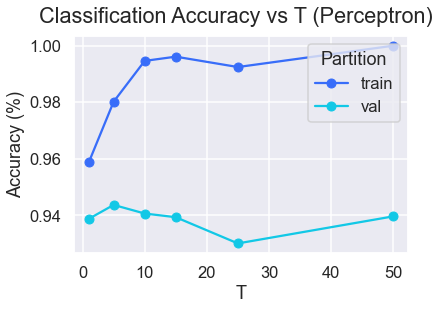

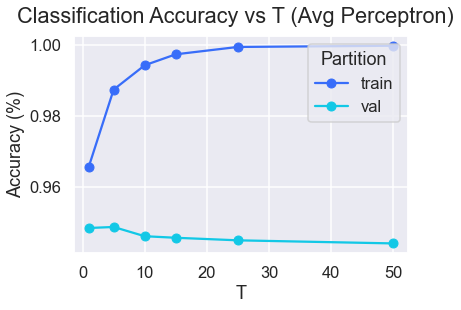

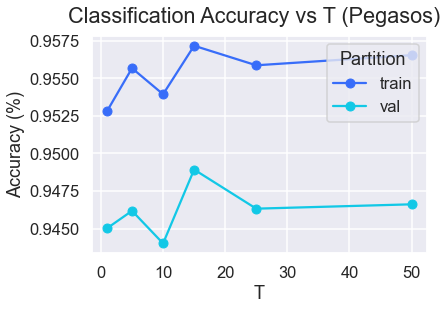

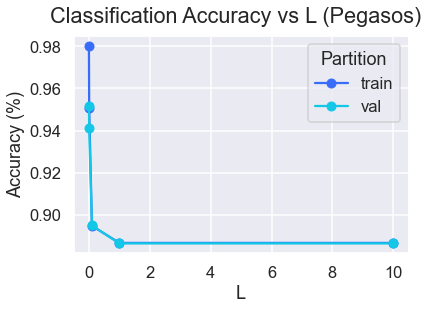

In [52]:
sns.set(style='darkgrid', context='talk', palette='rainbow')

utils.plot_tune_results('Perceptron', 'T', Ts, *pct_tune_results)
utils.plot_tune_results('Avg Perceptron', 'T', Ts, *avg_pct_tune_results)
utils.plot_tune_results('Pegasos', 'T', Ts, *peg_tune_results_T)
utils.plot_tune_results('Pegasos', 'L', Ls, *peg_tune_results_L)


For this time ```Tp = 15, Lp = 0.0010``` was the hyperparameter with better accuracy

In [53]:
# Hyperparameters
Tp = 15
Lp = 0.0010
thetha_t, thetha_t_0 = clf.pegasos(X_train, Y_train, Tp, Lp)
test_predicted_labels = clf.classify(X_test, thetha_t, thetha_t_0)
test_accuracy = clf.accuracy(test_predicted_labels, Y_test)
print("test bow accuracy: {}".format(test_accuracy))

best_theta = thetha_t
wordlist   = [word for (idx, word) in sorted(zip(dictionary.values(), dictionary.keys()))]
sorted_word_features = clf.most_explanatory_word(best_theta, wordlist)
print("Most Explanatory Word Features")
print(sorted_word_features[:10])



Iteration T: 0:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 1:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 2:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 3:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 4:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 5:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 6:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 7:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 8:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 9:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 10:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 11:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 12:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 13:   0%|          | 0/20736 [00:00<?, ?it/s]

Iteration T: 14:   0%|          | 0/20736 [00:00<?, ?it/s]

test bow accuracy: 0.9493707507594388
Most Explanatory Word Features
['excelente', 'perfecto', 'maravillosos', 'maravilloso', 'excelentes', 'recomendable', 'cómoda', 'gracias', 'casa', 'ergie']


### Playing with prediction

Here we play with a specific example of a negative and a positive comment from the **best theta** that was found in the previous selection.

In [60]:
one_comment = """Pasamos la semana santa con mi familia, incluidos niños, y sólo tengo buenas palabras para este hotel. Hemos disfrutado mucho estos días,
tanto del alojamiento, la playa, como del trato del personal. El hotel está situado en primera línea de una playa impresionante (bandera azul 2018-2019) a la 
cual se accede desde las habitaciones y todo está muy cerca, sin necesidad de carritos de golf. En la playa hay un poco de sargazo pero lo recogen varias veces 
al día con tractores y la playa está impecable. El resto de las instalaciones están muy cuidadas, bonitos jardines y restaurantes cuidados y limpios. 
Las habitaciones son grandes y cómodas, aunque a éstas si que les haría falta alguna reforma, sobre todo el baño. La comida del buffet en general es muy buena, sin grandres"""
# one_comment = """El hotel es terrible. La atención del personal deja mucho que desear y nunca tienen la información para orientar a las personas. 
# Cucarachas en el lobby. Malos olores por doquier. La habitación sumamente oscura y con olor a humedad. De noche es sumamente oscuro. 
# La electricidad se va en el hotel y por unos segundos queda todo absolutamente oscuro. En la piscina se bañan aves y en la playa ofrecen drogas. La comida también deja mucho qué desear.
# No recomendaría esta hotel ni a mi peor enemigo. Espero que el hotel no me responda con su estándar respuesta de “lamentamos que el hotel no haya cumplido con sus expectativas”. 
# No es una cuestión de expectativas; es una cuestión de un mínimo de calidad"""
X_experiment = utils.extract_unigram_vectors([one_comment], dictionary)
experiment_predicted_labels = clf.classify(X_experiment, thetha_t, thetha_t_0)
experiment_predicted_labels

array([1.])

#### Word Cloud of explanatory words 
\
Finally we will build a wordcloud with the words with the greatest "positive weight"

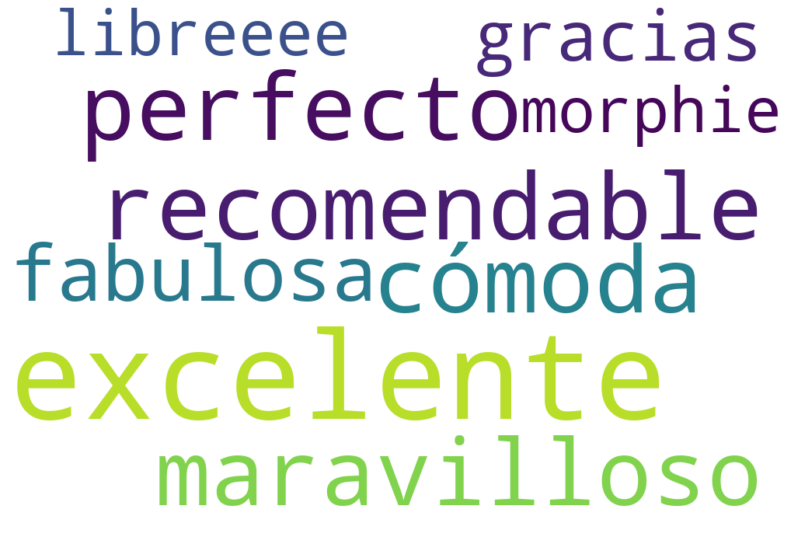

In [28]:
from wordcloud import WordCloud

unique = (" ").join(sorted_word_features[:10])

wordcloud = WordCloud(background_color="white", width=1000, height=700).generate(unique)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()